In [4]:
import gym
import numpy as np
import pandas as pd
import yfinance as yf
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import torch
import os
import optuna
import warnings
import random
import time
warnings.filterwarnings("ignore")

# === STEP 0: 재현을 위한 시드 고정 ===
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# === STEP 1: 데이터 수집 함수 ===
def fetch_data(start, end):
    #(1) 학습에 사용할 대표 ETF 5종의 심볼을 리스트로 저장
    tickers = ["SPY", "TLT", "GLD", "DBC", "SHY"]

    df = pd.DataFrame()
    #(2) 지정된 기간 동안의 일별 종가(Close) 데이터를 수집
    close_data = {}
    for ticker in tickers:
        df_temp = yf.download(ticker, start=start, end=end)["Close"]
        df = pd.concat([df, df_temp], axis=1)
        time.sleep(2)

    #(3) 결측치 제거
    df = df.dropna()

    #(4) 종가 데이터를 일간 수익률 데이터로 변환
    df = df.pct_change().dropna()
    return df

# ===  STEP 2. 사용자 정의 강화학습 환경 ===
class PortfolioEnvMonthly(gym.Env):
    
    #강화학습 환경의 기본 파라미터와 공간을 초기화
    def __init__(self, df, window_size=30, transaction_cost=0.002, rebalance_interval=20, seed=42):
        super().__init__()
        #(1) 수익률 데이터프레임(df) 저장
        self.df = df.reset_index(drop=True)

        #(2) 에이전트에게 제공할 입력의 기간 설정
        self.window_size = window_size

        #(3) 거래비용 설정
        self.transaction_cost = transaction_cost

        #(4) 자산 리밸런싱 주기 설정
        self.rebalance_interval = rebalance_interval

        #(5) 자산의 수(ETF 수)를 계산하여 저장
        self.asset_dim = df.shape[1]

        #(6) 에이전트 행동공간 정의
        self.action_space = spaces.Box(low=0, high=1, shape=(self.asset_dim,), dtype=np.float32)

        #(7) 관측 공간(observation space) 정의
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size, self.asset_dim), dtype=np.float32
        )

        #(8) 환경 초기화
        self.seed(SEED)
        self.reset()

    def seed(self, seed=None):
        np.random.seed(seed)
        random.seed(seed)
        return [seed]

    def reset(self):
        #(1) 시뮬레이션 시작 시점 설정
        self.current_step = self.window_size

        #(2) 초기 포트폴리오 가치 설정
        self.portfolio_value = 1.0

        #(3) 초기 자산 비중 설정
        self.weights = np.array([1.0 / self.asset_dim] * self.asset_dim)

        #(4) 수익률 및 낙폭 기록 초기화
        self.portfolio_returns = []
        self.drawdowns = []

        #(5) 초기 상태 반환
        return self._get_observation()

    def _get_observation(self):
        return self.df.iloc[self.current_step - self.window_size:self.current_step].values

    def step(self, action):
        #(1) 행동 정규화 및 유효성 검증
        action = np.clip(action, 0, 1)
        if np.sum(action) == 0: #합계가 0일 경우(비정상적 행동) → 균등분배로 대체
            action = np.ones_like(action) / len(action)
        else: #그 외에는 합이 1이 되도록 정규화
            action /= np.sum(action)

        #(2) 이전 자산 비중 저장 및 새 비중 적용
        prev_weights = self.weights
        self.weights = action

        #(3) 리밸런싱 구간 설정
        end_step = min(self.current_step + self.rebalance_interval, len(self.df))
        segment = self.df.iloc[self.current_step:end_step].values

        #(4) 리밸런싱 기간 동안의 수익률 누적 및 낙폭 계산
        peak_value = 0
        for daily_return in segment:
            #(4)-1 매일의 수익률 계산
            portfolio_return = np.dot(self.weights, daily_return)

            #(4)-2 포트폴리오 가치를 매일 누적 반영
            self.portfolio_value *= (1 + portfolio_return)

            #(4)-3 수익률 기록
            self.portfolio_returns.append(portfolio_return)

            #(4)-4 낙폭(drawdown) 계산: 최고점 대비 현재 가치의 하락률
            peak_value = max(peak_value, self.portfolio_value)
            if peak_value > 0: # 0으로 나누는 것을 방지
                drawdown = (peak_value - self.portfolio_value) / peak_value
            else:
                drawdown = 0 # 혹은 적절한 값
            self.drawdowns.append(drawdown)

        #(5) 거래 비용 적용
        turnover = np.sum(np.abs(action - prev_weights))
        cost = turnover * self.transaction_cost
        self.portfolio_value -= cost

        #(6) 보상 계산
        reward = self._calculate_reward()

        #(7) 시점 이동 및 종료 조건 확인
        self.current_step = end_step
        done = self.current_step >= len(self.df) - 1

        #(8) 다음 상태 반환
        return self._get_observation(), reward, done, {'portfolio_value': self.portfolio_value}

    #한 리밸런싱 주기 동안의 투자성과를 평가하여 보상값으로 반환
    def _calculate_reward(self):
        #(1) 하이퍼파라미터 λ 설정
        λ1, λ2, λ3 = 3.0, 1.5, 0.5

        #(2) 샤프 비율 계산: 수익의 안정성을 평가
        if len(self.portfolio_returns) >= self.rebalance_interval:
            window_returns = np.array(self.portfolio_returns[-self.rebalance_interval:])
            mean_return = np.mean(window_returns) #평균수익률
            std_return = np.std(window_returns) #수익률 표준편차
            sharpe = mean_return / (std_return + 1e-8) #샤프 비율 = 평균 / 표준편차, 1e-8은 0으로 나누는 문제 방지
        else:
            sharpe = 0
        
        #(3) 최대 낙폭(Max Drawdown) 계산
        max_dd = max(self.drawdowns[-self.rebalance_interval:] or [0])

        #(4) 전체 로그 수익률 계산
        log_return = np.log(self.portfolio_value)  # 전체 로그 성장률

        #(5) 거래 패널티 (리밸런싱 강도): 극단적인 집중 투자에 페널티를 주려는 의도
        transaction_penalty = np.sum(np.abs(self.weights))

        #(6) 보상값 계산
        reward = log_return - λ1 * max_dd + λ2 * sharpe - λ3 * transaction_penalty
        return reward

def objective(trial):
    try:
        #(1) 하이퍼파라미터 탐색 공간 정의
        ent_coef = trial.suggest_loguniform("ent_coef", 0.01, 0.05)
        learning_rate = trial.suggest_loguniform("learning_rate", 0.0001, 0.001)
        clip_range = trial.suggest_uniform("clip_range", 0.1, 0.3)
        gamma = trial.suggest_uniform("gamma", 0.9, 0.999)
        net_arch = trial.suggest_categorical("net_arch", [[64, 32], [64, 64], [128, 64], [128, 128]])

        #(2) 정책 신경망 구조 구성
        policy_kwargs = dict(
            activation_fn=torch.nn.SiLU,
            net_arch=[dict(pi=net_arch, vf=net_arch)]
        )

        #(3) 학습 및 테스트 환경 초기화
        train_env = PortfolioEnvMonthly(train_df)
        train_env.seed(SEED)
        test_env = PortfolioEnvMonthly(test_df)
        test_env.seed(SEED)

        #(4) 초기 관측값 안정성 검사
        obs = train_env.reset()
        if np.isnan(obs).any() or np.isinf(obs).any():
            raise ValueError("🚫 초기 관측값에 NaN 또는 inf 포함")

        #(5) 모델 생성 및 학습
        model = PPO("MlpPolicy", train_env, verbose=0,
                    policy_kwargs=policy_kwargs,
                    ent_coef=ent_coef,
                    learning_rate=learning_rate,
                    clip_range=clip_range,
                    gamma=gamma,
                    seed=SEED
                   )

        model.learn(total_timesteps=150000)

        #(6) 검증 데이터셋을 통한 평가 수행
        mean_reward, _ = evaluate_policy(model, test_env, n_eval_episodes=4)

        #(7) 평가 결과의 유효성 확인
        if np.isnan(mean_reward) or np.isinf(mean_reward):
            raise ValueError("mean_reward 값이 NaN 또는 inf")

        #(8) 최종값 반환
        return mean_reward

    except Exception as e:
        print(f"Trial failed due to error: {e}")
        return float("inf")

#(9)학습 데이터와 테스트 데이터 분리 
train_df = fetch_data("2005-01-01", "2023-12-31")
test_df = fetch_data("2024-01-01", "2025-03-31")

#(10) Optuna 스터디 객체 생성
study = optuna.create_study(direction="maximize")

#(11) 최적화 실행
study.optimize(objective, n_trials=50)

#(12) 최적 결과 요약 출력
print("Best trial found:")
print(f"Mean reward (test set): {-study.best_trial.value}")
print("Best hyperparameters:")
for k, v in study.best_trial.params.items():
    print(f"{k}: {v}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[I 2025-06-05 10:33:12,167] A new study created in memory with name: no-name-4af17a05-a42f-4ea9-b218-f13969d1ff36
[I 2025-06-05 10:35:10,265] Trial 0 finished with value: -3.7842619088478386 and parameters: {'ent_coef': 0.033282757709428686, 'learning_rate': 0.00024773247702893514, 'clip_range': 0.29541653677

Best trial found:
Mean reward (test set): 1.6159153878688812
Best hyperparameters:
ent_coef: 0.03964004687913023
learning_rate: 0.0002397841523159722
clip_range: 0.26035737930860936
gamma: 0.9949518295000087
net_arch: [64, 32]


In [5]:
#(1) 상위 trial 5개 추출
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:5]

#(2) 결과출력
print("Top 5 Trials (Sorted by Mean Reward on Test Set):\n")
for i, trial in enumerate(top_trials, 1):
    print(f"Rank {i}:")
    print(f"Mean reward (test set): {trial.value:.5f}")
    print("Hyperparameters:")
    for k, v in trial.params.items():
        print(f"     - {k}: {v}")
    print("-" * 40)

Top 5 Trials (Sorted by Mean Reward on Test Set):

Rank 1:
Mean reward (test set): -1.61592
Hyperparameters:
     - ent_coef: 0.03964004687913023
     - learning_rate: 0.0002397841523159722
     - clip_range: 0.26035737930860936
     - gamma: 0.9949518295000087
     - net_arch: [64, 32]
----------------------------------------
Rank 2:
Mean reward (test set): -1.85339
Hyperparameters:
     - ent_coef: 0.03973660377765656
     - learning_rate: 0.00012858640938871545
     - clip_range: 0.20609759243499523
     - gamma: 0.9892349246935729
     - net_arch: [64, 32]
----------------------------------------
Rank 3:
Mean reward (test set): -1.86266
Hyperparameters:
     - ent_coef: 0.03751151962887243
     - learning_rate: 0.0001806525416949427
     - clip_range: 0.2514871516443905
     - gamma: 0.9808957406349333
     - net_arch: [64, 32]
----------------------------------------
Rank 4:
Mean reward (test set): -1.92936
Hyperparameters:
     - ent_coef: 0.04038940762886268
     - learning_rate

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 224          |
|    ep_rew_mean          | -52.4        |
| time/                   |              |
|    fps                  | 1249         |
|    iterations           | 10           |
|    time_elapsed         | 16           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0031252168 |
|    clip_fraction        | 0.00107      |
|    clip_range           | 0.26         |
|    entropy_loss         | -7.48        |
|    explained_variance   | 0.143        |
|    learning_rate        | 0.00024      |
|    loss                 | 18.1         |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00216     |
|    std                  | 1.09         |
|    value_loss           | 47.3         |
---

[*********************100%***********************]  1 of 1 completed

모델 저장 완료: models/ray_dalio_portfolio_model.zip



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


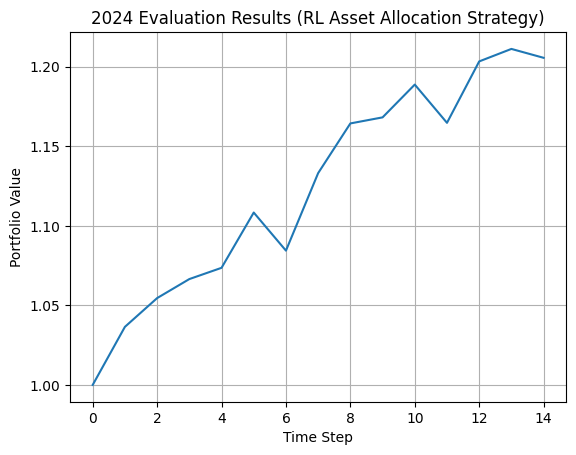

In [9]:
# === STEP 3: 학습용 데이터 로딩 및 학습 ===
#(1) 학습용 데이터 수집
train_df = fetch_data("2005-01-01", "2023-12-31")

#(2) 사용자 환경 설정2
train_env = PortfolioEnvMonthly(train_df)
train_env.seed(SEED)

policy_kwargs = dict(
    activation_fn=torch.nn.SiLU,  # Swish = SiLU
    net_arch=[dict(pi=[64,32], vf=[64,32])]
)
#(3) PPO 에이전트 초기화
model = PPO("MlpPolicy", train_env, verbose=1, policy_kwargs=policy_kwargs, seed=SEED,
            clip_range=0.26035737930860936, gamma=0.9949518295000087,
            ent_coef=0.03964004687913023, learning_rate=0.0002397841523159722,
            # tensorboard_log="./ppo_tensorboard_logs/"
           )

#(4) 학습시작
model.learn(total_timesteps=300000, log_interval=10)

# === STEP 4: 모델 저장 ===
#(1) 모델 저장 폴더 생성
os.makedirs("models", exist_ok=True)

#(2) 모델 경로 설정
model_path = "models/ray_dalio_portfolio_model"

#(3) 학습된 모델 저장
model.save(model_path)

print(f"모델 저장 완료: {model_path}.zip")

# === STEP 5: 검증용 2024년도 데이터 로딩 및 모델 로딩 ===
#(1) 테스트 데이터 수집
test_df = fetch_data("2024-01-01", "2025-03-31")
test_env = PortfolioEnvMonthly(test_df)

#(2) 저장된 모델 로딩
loaded_model = PPO.load(model_path, env=test_env)

#(3) 환경 초기화 및 초기 상태 준비
obs = test_env.reset()
portfolio_values = [test_env.portfolio_value]
done = False

#(4) 행동 정규화 함수 정의
def normalize_action(action):
    action = np.maximum(action, 0)
    total = np.sum(action)
    return action / total if total > 0 else np.ones_like(action) / len(action)

#(5) 시뮬레이션 실행
while not done:
    action, _ = loaded_model.predict(obs, deterministic=True)
    action = normalize_action(action)
    obs, reward, done, info = test_env.step(action)
    portfolio_values.append(info['portfolio_value'])

#(6) 결과 시각화
plt.plot(portfolio_values)
plt.title("2024 Evaluation Results (RL Asset Allocation Strategy)")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.grid()
plt.show()